# Chronicle Flood Database Intersection with GHSL Built Area dataset

This notebook provides a comprehensive analysis of the Chronicle urban flood dataset, containing over 880,000 flood events worldwide from 2000-2025.


# Imports & Configuration

In [8]:
import pandas as pd
import geopandas as gpd
from shapely import wkt, geometry
from shapely.geometry import box
import rasterio
from rasterstats import zonal_stats
import numpy as np
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math
# --- CONFIGURATION ---

# File Paths
chronicle_ds_csv_path = r"D:\Development\RESEARCH\urban_flood_database\chronicle\chronicle_preliminary_huji.csv"
ghs_urban_raster_path = r"D:\Development\RESEARCH\Raanana\data\esa_worldcover\GHS_BUILT_S_E2020_GLOBE_R2023A_54009_100_V1_0.tif"

# Processing Settings
# Set to an integer (e.g., 10000) for testing, or None for full dataset
SAMPLE_SIZE = None

# Data Loading & Processing

In [ ]:
if SAMPLE_SIZE:
    chronicle_raw_df = pd.read_csv(chronicle_ds_csv_path, nrows=SAMPLE_SIZE)
else:
    chronicle_raw_df = pd.read_csv(chronicle_ds_csv_path)

# 2. Parse Geometries
print("Parsing WKT geometries...")
chronicle_raw_df['geometry'] = chronicle_raw_df['geometry_wkt'].apply(wkt.loads)

# 3. Create GeoDataFrame
chronicle_gdf = gpd.GeoDataFrame(chronicle_raw_df, geometry='geometry')
chronicle_gdf.set_crs(epsg=4326, inplace=True)

# 4. Reproject
with rasterio.open(ghs_urban_raster_path) as src:
    ghs_raster_crs = src.crs
    ghs_nodata_value = src.nodata
    print(f"Raster CRS: {ghs_raster_crs}")
    
    print("Reprojecting polygons...")
    chronicle_projected_gdf = chronicle_gdf.to_crs(ghs_raster_crs)

# 5. Calculate Zonal Statistics (WITH PROGRESS TRACKING)
print("Calculating zonal stats in chunks...")

# -- PROGRESS LOGIC START --
total_rows = len(chronicle_projected_gdf)
# We want 10 updates, so we divide total rows by 10
chunk_size = math.ceil(total_rows / 10) 
all_stats = []

# Iterate through the DataFrame in chunks
for i in range(0, total_rows, chunk_size):
    # Slice the dataframe
    subset = chronicle_projected_gdf.iloc[i : i + chunk_size]
    
    # Run stats just for this chunk
    chunk_stats = zonal_stats(
        subset,
        ghs_urban_raster_path,
        stats=['sum'],
        nodata=ghs_nodata_value
    )
    
    # Accumulate results
    all_stats.extend(chunk_stats)
    
    # Calculate and print progress
    current_row = min(i + chunk_size, total_rows)
    percent_complete = int((current_row / total_rows) * 100)
    print(f"{percent_complete}% complete... ({current_row}/{total_rows})")

# Convert accumulated list to DataFrame
urban_stats_df = pd.DataFrame(all_stats)
# -- PROGRESS LOGIC END --

# 6. Calculate Urban Percentage
print("Calculating percentages...")
chronicle_projected_gdf['urban_built_up_area_m2'] = urban_stats_df['sum'].fillna(0)
chronicle_projected_gdf['polygon_total_area_m2'] = chronicle_projected_gdf.area

chronicle_projected_gdf['urban_percentage'] = np.where(
    chronicle_projected_gdf['polygon_total_area_m2'] > 0,
    (chronicle_projected_gdf['urban_built_up_area_m2'] / chronicle_projected_gdf['polygon_total_area_m2']) * 100,
    0
)

# 7. Final Clean DataFrame
chronicle_urban_df = pd.DataFrame(chronicle_projected_gdf.drop(columns='geometry'))

print(f"--- Done! Processed {len(chronicle_urban_df)} records. ---")

## Save as a pickle

In [9]:
# Save the DataFrame to a pickle file at the specified path
# chronicle_urban_df.to_pickle(r"D:\Development\RESEARCH\urban_flood_database\chronicle\chronicle_urban_df.pkl")

In [10]:
# Load the DataFrame from the specified path
chronicle_urban_df = pd.read_pickle(r"D:\Development\RESEARCH\urban_flood_database\chronicle\chronicle_urban_df.pkl")

In [13]:
# 1. Filter rows with percentage > 100
anomalies = thresh_chronicle_urban_df[thresh_chronicle_urban_df['urban_percentage'] > 100]
count = len(anomalies)


print(f"Total events checked: {len(thresh_chronicle_urban_df)}")
print(f"Events with > 100% urban area: {count}")

if count > 0:
    max_val = anomalies['urban_percentage'].max()
    print(f"Highest value found: {max_val:.2f}%")
    
    print("\nTop 5 Anomalies (Preview):")
    # Show UUID, Percentage, and Total Area (often happens in very small polygons)
    print(anomalies[['uuid', 'urban_percentage', 'polygon_total_area_m2']].head())
else:
    print("Status: OK. No values above 100% found.")

--- Data Integrity Check ---
Total events checked: 214204
Events with > 100% urban area: 0
Status: OK. No values above 100% found.


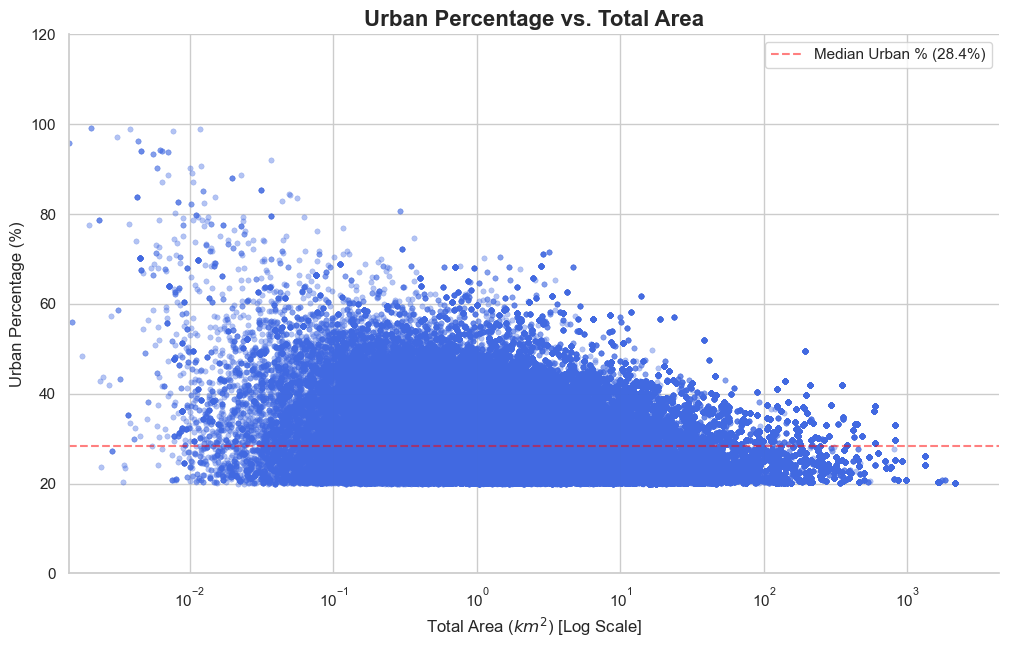

In [14]:

# 1. Create a copy and convert area to km² for better readability
# (1 km² = 1,000,000 m²)
df_plot = thresh_chronicle_urban_df.copy()
df_plot['area_km2'] = df_plot['polygon_total_area_m2'] / 1_000_000

# 2. Setup the figure
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# 3. Create Scatter Plot
sns.scatterplot(
    data=df_plot,
    x='area_km2',
    y='urban_percentage',
    alpha=0.4,       # Transparency helps visualize overlapping points
    edgecolor=None,  # Removes borders from dots for a cleaner look
    s=15,            # Dot size
    color='royalblue'
)

# 4. Set Log Scale for X-axis (Crucial for Area distribution)
plt.xscale('log')

# 5. Set limits and styling
plt.ylim(0, 120)
plt.xlim(left=df_plot['area_km2'].min()) # Start from the smallest polygon

plt.title('Urban Percentage vs. Total Area', fontsize=16, fontweight='bold')
plt.xlabel('Total Area ($km^2$) [Log Scale]', fontsize=12)
plt.ylabel('Urban Percentage (%)', fontsize=12)

# 6. Add a visual helper line (e.g., median urban percentage)
median_val = df_plot['urban_percentage'].median()
plt.axhline(median_val, color='red', linestyle='--', alpha=0.5, label=f'Median Urban % ({median_val:.1f}%)')
plt.legend()

sns.despine()
plt.show()